In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Google_stock_data[1].csv to Google_stock_data[1].csv
User uploaded file "Google_stock_data[1].csv" with length 493042 bytes


In [3]:
# Import Dependencies
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the Dataset
file_path = "Google_stock_data[1].csv"

# Read and prepare data
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df[features]


In [4]:
# Normalize the Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create Sequences for LSTM + Attention
window_size = 30
X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i])
    y.append(scaled_data[i, 3])  # Close price
X, y = np.array(X), np.array(y)

# Train-Test Split
split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Define LSTM + Attention Model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_out = LSTM(64, return_sequences=True)(input_layer)
lstm_out = Dropout(0.2)(lstm_out)

In [5]:
# Attention mechanism
attention = Attention()([lstm_out, lstm_out])
context = Concatenate()([lstm_out, attention])
context_vector = LSTM(32)(context)
dense_out = Dense(1)(context_vector)

model = Model(inputs=input_layer, outputs=dense_out)
model.compile(optimizer='adam', loss='mse')

# Train the Model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0025 - val_loss: 0.0049
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 2.3482e-04 - val_loss: 0.0023
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 2.0089e-04 - val_loss: 0.0013
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 1.6905e-04 - val_loss: 0.0018
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 1.7818e-04 - val_loss: 0.0017
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 1.3798e-04 - val_loss: 0.0015
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.6439e-04 - val_loss: 0.0013
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 1.5863e-04 - val_loss: 0.0012
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1.9383e-04 - val_loss: 0.0012
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 1.1442e-04 - val_loss: 6.5484e-04
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 1.0317e-04 - val_loss: 0.00

In [6]:
# Evaluate the Model
y_pred_scaled = model.predict(X_test)
y_test_scaled = y_test.reshape(-1, 1)

# Inverse transform predictions (replacing Close in scaled dataset)
def inverse_transform_close(pred_close_scaled):
    dummy = np.zeros((len(pred_close_scaled), 5))
    dummy[:, 3] = pred_close_scaled.ravel()
    return scaler.inverse_transform(dummy)[:, 3]

predicted_close = inverse_transform_close(y_pred_scaled)
actual_close = inverse_transform_close(y_test_scaled)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [7]:
# Compute RMSE and MAE
rmse = np.sqrt(mean_squared_error(actual_close, predicted_close))
mae = mean_absolute_error(actual_close, predicted_close)

print(f"Attention LSTM RMSE: {rmse:.2f}")
print(f"Attention LSTM MAE: {mae:.2f}")

Attention LSTM RMSE: 3.82
Attention LSTM MAE: 2.83


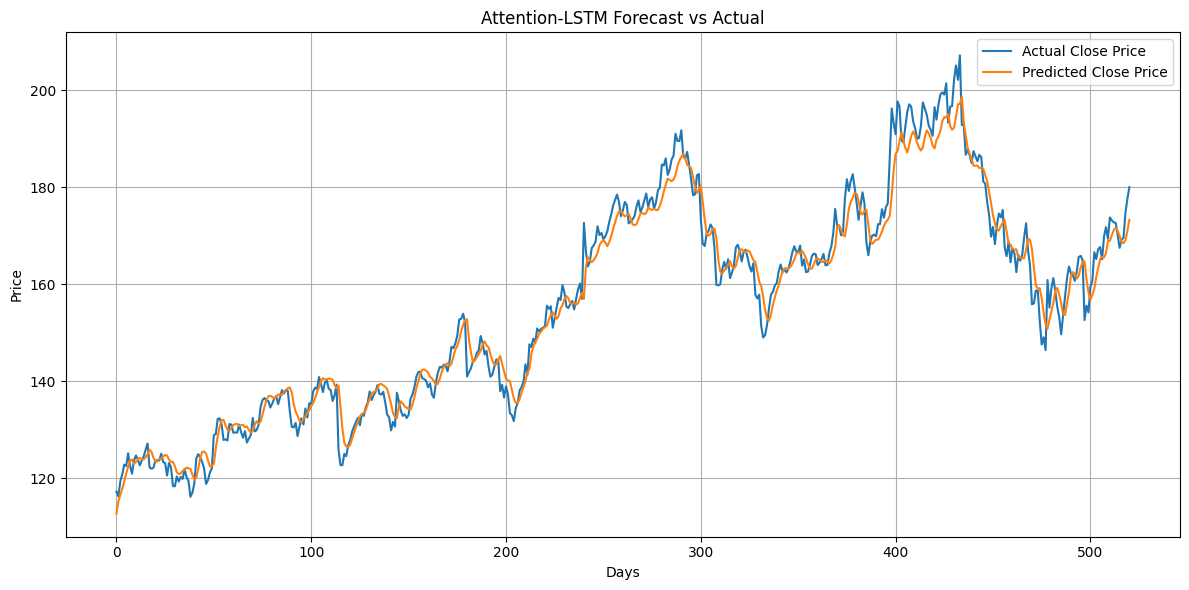

In [8]:
# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(actual_close, label='Actual Close Price')
plt.plot(predicted_close, label='Predicted Close Price')
plt.title('Attention-LSTM Forecast vs Actual')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Additional attention layer and change in hyperparameter: the learning rate

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 6.2774e-05 - val_loss: 5.6366e-04
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 5.6734e-05 - val_loss: 4.6407e-04
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 5.7181e-05 - val_loss: 4.8559e-04
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 5.7620e-05 - val_loss: 5.3657e-04
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 5.4199e-05 - val_loss: 5.3130e-04
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 5.6825e-05 - val_loss: 6.8888e-04
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 5.7024e-05 - val_loss: 5.2486e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Attention LSTM RMSE: 4.41
Attention LSTM MAE: 3.39


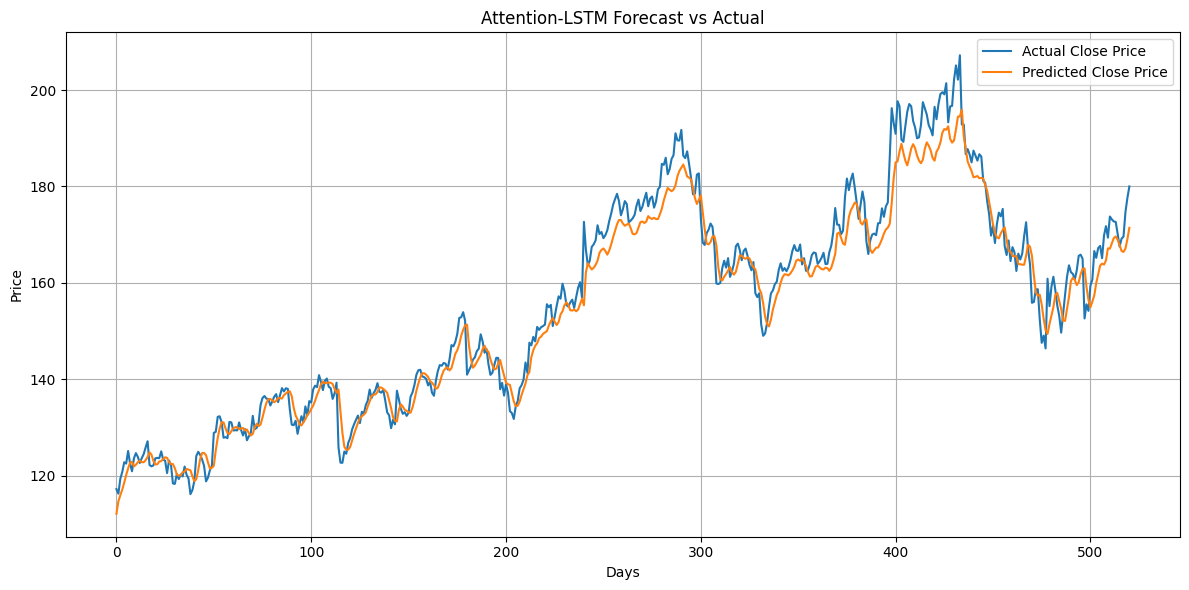

In [9]:
from tensorflow.keras.optimizers import Adam

model2 = Model(inputs=input_layer, outputs=dense_out)
model2.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

#Train the Model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate the Model
y_pred_scaled = model2.predict(X_test)
y_test_scaled = y_test.reshape(-1, 1)

# Inverse transform predictions (replacing Close in scaled dataset)
def inverse_transform_close(pred_close_scaled):
    dummy = np.zeros((len(pred_close_scaled), 5))
    dummy[:, 3] = pred_close_scaled.ravel()
    return scaler.inverse_transform(dummy)[:, 3]

predicted_close = inverse_transform_close(y_pred_scaled)
actual_close = inverse_transform_close(y_test_scaled)

# Compute RMSE and MAE
rmse = np.sqrt(mean_squared_error(actual_close, predicted_close))
mae = mean_absolute_error(actual_close, predicted_close)

print(f"Attention LSTM RMSE: {rmse:.2f}")
print(f"Attention LSTM MAE: {mae:.2f}")

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(actual_close, label='Actual Close Price')
plt.plot(predicted_close, label='Predicted Close Price')
plt.title('Attention-LSTM Forecast vs Actual')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
